<a href="https://colab.research.google.com/github/Jeetkavaiya/Assignment-4_Airbnb-Price-Prediction/blob/main/Tier%201%20Cities/Tier1_Big_Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Price Prediction: XGBoost vs Neural Networks - Tier 1 (Big Cities)
## EAS 510 Assignment 4

---

### How to Download Data from Inside Airbnb

1. **Visit Inside Airbnb**: Go to https://insideairbnb.com/get-the-data/
2. **Download for Each City** (Tier 1 - Big Cities):
   - **New York City, NY** - Download listings.csv (use most recent available, September 2024 recommended)
   - **Los Angeles, CA** - Download listings.csv
   - **San Francisco, CA** - Download listings.csv
   - **Chicago, IL** - Download listings.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning & Models
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Neural Networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 2. DATA LOADING

In [5]:
print("\n" + "="*60)
print("TIER 1 (BIG CITIES) - DATA LOADING")
print("="*60 + "\n")

cities = {
    'NYC': 'NYC.csv',
    'LA': 'LA.csv',
    'SF': 'SF.csv',
    'Chicago': 'Chicago.csv'
}

# Load all city data
data_dfs = {}
for city_name, filename in cities.items():
    try:
        df = pd.read_csv(filename)
        df['city'] = city_name
        data_dfs[city_name] = df
        print(f"Loaded {city_name}: {df.shape[0]:,} listings, {df.shape[1]} columns")
    except FileNotFoundError:
        print(f"File not found: {filename}")

# Combine all city data
df_combined = pd.concat(list(data_dfs.values()), ignore_index=True)
print(f"\n{'='*60}")
print(f"COMBINED DATA (Tier 1 - Big Cities)")
print(f"{'='*60}")
print(f"Total listings: {df_combined.shape[0]:,}")
print(f"Total columns: {df_combined.shape[1]}")
print(f"Cities included: {', '.join(data_dfs.keys())}")
print(f"{'='*60}\n")

print("First few rows of combined data:")
print(df_combined.head())
print(f"\nData types:{df_combined.dtypes}")


TIER 1 (BIG CITIES) - DATA LOADING

Loaded NYC: 36,111 listings, 19 columns
Loaded LA: 45,886 listings, 19 columns
Loaded SF: 7,780 listings, 19 columns
Loaded Chicago: 8,604 listings, 19 columns

COMBINED DATA (Tier 1 - Big Cities)
Total listings: 98,381
Total columns: 19
Cities included: NYC, LA, SF, Chicago

First few rows of combined data:
     id                                               name  host_id  \
0  2595  Skylit Studio Oasis | Midtown Manhattan Sanctuary     2845   
1  6848                   Only 2 stops to Manhattan studio    15991   
2  6872  Uptown Sanctuary w/ Private Bath (Month to Month)    16104   
3  6990                            UES Beautiful Blue Room    16800   
4  7064  Amazing location! Wburg. Large, bright & tranquil    17297   

   host_name neighbourhood_group neighbourhood  latitude  longitude  \
0   Jennifer           Manhattan       Midtown  40.75356  -73.98559   
1      Allen            Brooklyn  Williamsburg  40.70935  -73.95342   
2  Kahshanna 


# 3. DATA PREPROCESSING & CLEANING

In [12]:
import re

print(f"\n{'='*60}")
print("DATA PREPROCESSING REPORT")
print(f"{'='*60}")

df = df_combined.copy()
initial_rows = len(df)
print(f"Starting with {initial_rows:,} rows")

# Clean price
def clean_price(price_str):
    """Convert '$66.00' to 66.0"""
    if pd.isna(price_str):
        return np.nan
    if isinstance(price_str, (int, float)):
        return float(price_str)
    cleaned = re.sub(r'[$,]', '', str(price_str))
    try:
        return float(cleaned)
    except:
        return np.nan

df['price'] = df['price'].apply(clean_price)
print(f"Cleaned price column")
print(f"Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

# Remove missing price
df = df.dropna(subset=['price'])
print(f"Removed rows with missing price: {initial_rows - len(df):,} dropped")

# Remove price outliers
df = df[df['price'] > 20]  # Minimum reasonable price
df = df[df['price'] < 5000]  # Remove extreme outliers
print(f"Filtered price range ($20 - $5,000): {len(df):,} rows remaining")

# Clean bathroom text
def extract_bathroom_count(bath_value):
    """Extract numeric value - handles both text ('2 baths') and numeric values"""
    if pd.isna(bath_value):
        return np.nan
    # If already numeric
    if isinstance(bath_value, (int, float)):
        return float(bath_value)
    # If text, extract number
    match = re.search(r'(\d+\.?\d*)', str(bath_value))
    if match:
        return float(match.group(1))
    return np.nan

# Check which bathroom column exists and create bathrooms_numeric
if 'bathrooms_text' in df.columns:
    df['bathrooms_numeric'] = df['bathrooms_text'].apply(extract_bathroom_count)
    print(f"Converted bathrooms_text to numeric")
elif 'bathrooms' in df.columns:
    df['bathrooms_numeric'] = df['bathrooms'].apply(extract_bathroom_count)
    print(f"Converted bathrooms to numeric")
else:
    # If no bathroom column exists, create with default value
    print(f"Warning: No bathroom column found. Creating default bathrooms_numeric = 1")
    df['bathrooms_numeric'] = 1.0

base_features = [
    'accommodates', 'bedrooms', 'beds', 'bathrooms_numeric',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'number_of_reviews',
    'availability_365', 'minimum_nights', 'maximum_nights'
]

# Handling missing values and ensuring all base_features exist
for col in base_features:
    if col not in df.columns:
        print(f"Warning: {col} not found in dataset. Creating with default value.")
        # Assign sensible defaults for missing base features
        if col in ['accommodates', 'bedrooms', 'beds']:
            df[col] = 1.0 # Default to 1 for counts
        elif 'review_scores' in col:
            df[col] = 4.0 # Default to a neutral review score if missing
        elif col == 'maximum_nights':
            df[col] = 365.0 # Default to a year
        else:
            df[col] = 0.0 # General default for other numerical features

    # Convert to numeric
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values with median after ensuring the column exists
    median_val = df[col].median()
    if pd.isna(median_val): # If the whole column is NaN, median will be NaN. Fill with a general default instead.
        if col in ['accommodates', 'bedrooms', 'beds']:
            df[col].fillna(1.0, inplace=True)
            median_val = 1.0
        elif 'review_scores' in col:
            df[col].fillna(4.0, inplace=True)
            median_val = 4.0
        elif col == 'maximum_nights':
            df[col].fillna(365.0, inplace=True)
            median_val = 365.0
        else:
            df[col].fillna(0.0, inplace=True)
            median_val = 0.0
    else:
        df[col].fillna(median_val, inplace=True)

    missing_pct = (df[col].isnull().sum() / len(df)) * 100
    if missing_pct > 0: # This should ideally not happen if defaults and median fill work as expected
        print(f"  {col}: still has {df[col].isnull().sum()} values ({missing_pct:.1f}%) after fillna")

print(f"All missing values handled")
print(f"\nFinal dataset: {len(df):,} rows, {df.shape[1]} columns")
print(f"{'='*60}\n")


DATA PREPROCESSING REPORT
Starting with 98,381 rows
Cleaned price column
Price range: $8.00 - $85000.00
Removed rows with missing price: 26,758 dropped
Filtered price range ($20 - $5,000): 70,991 rows remaining
All missing values handled

Final dataset: 70,991 rows, 31 columns



# 4. FEATURE ENGINEERING (4+ Additional Features)

In [20]:
print(f"{'='*60}")
print("FEATURE ENGINEERING")
print(f"{'='*60}\n")

# Feature 1: Average Review Score
print("Feature 1: avg_review_score")
review_cols = [
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value'
]
df['avg_review_score'] = df[review_cols].mean(axis=1)
print(f"Range: {df['avg_review_score'].min():.2f} - {df['avg_review_score'].max():.2f}")

# Feature 2: Price Per Bedroom
print("Feature 2: price_per_bedroom")
df['price_per_bedroom'] = df['price'] / (df['bedrooms'] + 1)  # +1 to avoid division by zero
print(f"Range: ${df['price_per_bedroom'].min():.2f} - ${df['price_per_bedroom'].max():.2f}")

# Feature 3: Review Activity (reviews per month)
print("Feature 3: review_activity")
if 'reviews_per_month' in df.columns:
    df['review_activity'] = pd.to_numeric(df['reviews_per_month'], errors='coerce')
    df['review_activity'].fillna(0, inplace=True)
else:
    # Calculate from number_of_reviews
    df['review_activity'] = df['number_of_reviews'] / (df['availability_365'] / 30 + 1)
print(f"  Range: {df['review_activity'].min():.2f} - {df['review_activity'].max():.2f}")

# Feature 4: Amenities Count
print("Feature 4: amenities_count")
if 'amenities' in df.columns:
    df['amenities_count'] = df['amenities'].apply(
        lambda x: len(eval(x)) if isinstance(x, str) and x.startswith('[') else 0
    )
else:
    df['amenities_count'] = 0  # Default if column doesn't exist
print(f"  Range: {df['amenities_count'].min()} - {df['amenities_count'].max()}")

# Feature 5: Property Type Encoded
print("Feature 5: property_type_encoded")
if 'property_type' in df.columns:
    le_property = LabelEncoder()
    df['property_type_encoded'] = le_property.fit_transform(
        df['property_type'].fillna('Unknown')
    )
    print(f"  Categories: {len(le_property.classes_)}")
else:
    df['property_type_encoded'] = 0

# Feature 6: Room Type Encoded
print("Feature 6: room_type_encoded")
if 'room_type' in df.columns:
    le_room = LabelEncoder()
    df['room_type_encoded'] = le_room.fit_transform(
        df['room_type'].fillna('Unknown')
    )
    print(f"  Categories: {len(le_room.classes_)}")
else:
    df['room_type_encoded'] = 0

# Feature 7: Host Experience
print("Feature 7: host_is_superhost_encoded")
if 'host_is_superhost' in df.columns:
    df['host_is_superhost_encoded'] = (df['host_is_superhost'] == 't').astype(int)
else:
    df['host_is_superhost_encoded'] = 0

# Complete feature list (base + engineered)
engineered_features = [
    'avg_review_score', 'price_per_bedroom', 'review_activity',
    'amenities_count', 'property_type_encoded', 'room_type_encoded',
    'host_is_superhost_encoded'
]

all_features = base_features + engineered_features

print(f"\nFeature Engineering Complete!")
print(f"  Base features: {len(base_features)}")
print(f"  Engineered features: {len(engineered_features)}")
print(f"  Total features: {len(all_features)}")

FEATURE ENGINEERING

Feature 1: avg_review_score
Range: 4.00 - 4.00
Feature 2: price_per_bedroom
Range: $10.50 - $2497.50
Feature 3: review_activity
  Range: 0.00 - 122.76
Feature 4: amenities_count
  Range: 0 - 0
Feature 5: property_type_encoded
Feature 6: room_type_encoded
  Categories: 4
Feature 7: host_is_superhost_encoded

Feature Engineering Complete!
  Base features: 15
  Engineered features: 7
  Total features: 22


# 5. PREPARE TRAIN/VALIDATION/TEST SPLITS

In [18]:
print(f"{'='*60}")
print("DATA SPLITTING & SCALING")
print(f"{'='*60}\n")

df = df.dropna(subset=all_features + ['price'])

X = df[all_features].values
y = df['price'].values

print(f"Dataset: {X.shape[0]:,} samples, {X.shape[1]} features")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"\nTrain/Validation/Test Split:")
print(f"Training:{len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation:{len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:{len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

DATA SPLITTING & SCALING

Dataset: 70,991 samples, 22 features

Train/Validation/Test Split:
Training:49,693 samples (70.0%)
Validation:10,649 samples (15.0%)
Test:10,649 samples (15.0%)


# 6. XGBOOST MODEL TRAINING & EVALUATION

In [25]:
print(f"{'='*60}")
print("XGBOOST MODEL")
print(f"{'='*60}\n")

xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    random_state=42,
    n_jobs=-1
)

print("XGBoost Hyperparameters:")
print(f"  n_estimators: {xgb_model.n_estimators}")
print(f"  learning_rate: {xgb_model.learning_rate}")
print(f"  max_depth: {xgb_model.max_depth}")
print(f"  subsample: {xgb_model.subsample}")

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=50
)

y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)
y_test_pred_xgb = xgb_model.predict(X_test)

def evaluate_model(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{set_name} Set Performance:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

print(f"\n{'='*60}")
print("XGBOOST EVALUATION")
print(f"{'='*60}")

xgb_train_metrics = evaluate_model(y_train, y_train_pred_xgb, "Training")
xgb_val_metrics = evaluate_model(y_val, y_val_pred_xgb, "Validation")
xgb_test_metrics = evaluate_model(y_test, y_test_pred_xgb, "Test")

XGBOOST MODEL

XGBoost Hyperparameters:
  n_estimators: 200
  learning_rate: 0.05
  max_depth: 7
  subsample: 0.8
[0]	validation_0-rmse:320.30005
[50]	validation_0-rmse:61.89032
[100]	validation_0-rmse:46.22062
[150]	validation_0-rmse:45.47116
[199]	validation_0-rmse:46.32325

XGBOOST EVALUATION

Training Set Performance:
  RMSE: $30.76
  MAE:  $5.00
  R²:   0.9914
  MAPE: 1.60%

Validation Set Performance:
  RMSE: $46.32
  MAE:  $6.10
  R²:   0.9794
  MAPE: 1.75%

Test Set Performance:
  RMSE: $46.00
  MAE:  $6.41
  R²:   0.9813
  MAPE: 1.81%


# 7. NEURAL NETWORK MODEL 1: MEDIUM ARCHITECTURE

In [27]:
print(f"{'='*60}")
print("NEURAL NETWORK MODEL 1 (Medium Architecture)")
print(f"{'='*60}\n")

def build_nn_medium(n_features):
    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    return model

nn_model_1 = build_nn_medium(X_train_scaled.shape[1])

print("Model Architecture (Medium):")
nn_model_1.summary()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

print("\nTraining Neural Network Model 1")
history_nn1 = nn_model_1.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"Neural Network Model 1 training complete")

y_train_pred_nn1 = nn_model_1.predict(X_train_scaled, verbose=0).flatten()
y_val_pred_nn1 = nn_model_1.predict(X_val_scaled, verbose=0).flatten()
y_test_pred_nn1 = nn_model_1.predict(X_test_scaled, verbose=0).flatten()

print(f"\n{'='*60}")
print("NEURAL NETWORK MODEL 1 EVALUATION")
print(f"{'='*60}")

nn1_train_metrics = evaluate_model(y_train, y_train_pred_nn1, "Training")
nn1_val_metrics = evaluate_model(y_val, y_val_pred_nn1, "Validation")
nn1_test_metrics = evaluate_model(y_test, y_test_pred_nn1, "Test")

NEURAL NETWORK MODEL 1 (Medium Architecture)

Model Architecture (Medium):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,825 (54.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network Model 1...
Epoch 1/150
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 46018.8594 - mae: 94.8702 - val_loss: 76.6915 - val_mae: 6.6465 - learning_rate: 0.0010
Epoch 2/150
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4615.4155 - mae: 33.1302 - val_loss: 370.0018 - val_mae: 9.1581 - learning_rate: 0.0010
Epoch 3/150
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3756.8594 - mae: 30.4431 - val_loss: 171.5700 - val_mae: 8.0320 - learning_rate: 0.0010
Epoch 4/150
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3649.6318 - mae: 29.0959 - val_loss: 609.1766 - val_mae: 10.2459 - learning_rate: 0.0010
Epoch 5/150
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 3606.0330 - mae: 28.6180 - val_loss: 664.8574 - val_mae: 17.7883 - learning_rate: 0.0010
Epoch 6/150
1529/1553 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3514.8052 - mae: 28.0027
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1553/1553 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

# 8. NEURAL NETWORK MODEL 2: DEEP ARCHITECTURE

In [28]:
print(f"{'='*60}")
print("NEURAL NETWORK MODEL 2 (Deep Architecture)")
print(f"{'='*60}\n")

def build_nn_deep(n_features):
    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )

    return model

nn_model_2 = build_nn_deep(X_train_scaled.shape[1])

print("Model Architecture (Deep):")
nn_model_2.summary()

print("\nTraining Neural Network Model 2")
history_nn2 = nn_model_2.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"Neural Network Model 2 training complete")

y_train_pred_nn2 = nn_model_2.predict(X_train_scaled, verbose=0).flatten()
y_val_pred_nn2 = nn_model_2.predict(X_val_scaled, verbose=0).flatten()
y_test_pred_nn2 = nn_model_2.predict(X_test_scaled, verbose=0).flatten()

print(f"\n{'='*60}")
print("NEURAL NETWORK MODEL 2 EVALUATION")
print(f"{'='*60}")

nn2_train_metrics = evaluate_model(y_train, y_train_pred_nn2, "Training")
nn2_val_metrics = evaluate_model(y_val, y_val_pred_nn2, "Validation")
nn2_test_metrics = evaluate_model(y_test, y_test_pred_nn2, "Test")

NEURAL NETWORK MODEL 2 (Deep Architecture)

Model Architecture (Deep):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 256)            │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,665 (194.00 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Neural Network Model 2
Epoch 1/150
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 37254.0664 - mae: 90.9862 - val_loss: 639.2390 - val_mae: 16.4896 - learning_rate: 5.0000e-04
Epoch 2/150
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5844.8340 - mae: 38.0666 - val_loss: 880.9402 - val_mae: 14.9657 - learning_rate: 5.0000e-04
Epoch 3/150
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4670.8540 - mae: 34.4833 - val_loss: 78.0495 - val_mae: 7.2230 - learning_rate: 5.0000e-04
Epoch 4/150
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4292.6938 - mae: 32.5633 - val_loss: 1441.6304 - val_mae: 25.5147 - learning_rate: 5.0000e-04
Epoch 5/150
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4673.9233 - mae: 31.5121 - val_loss: 3228.8616 - val_mae: 31.0661 - learning_rate: 5.0000e-04
Epoch 6/150
3106/3106 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3868.1472 - mae: 29.7058 - val_loss: 2657.9402 - val_mae: 34.9146 - learning_rate: 5.0000e-04
Epoch 7/150
3106/3106 ━━━━━━

# 9. VISUALIZATION: TRAINING HISTORY

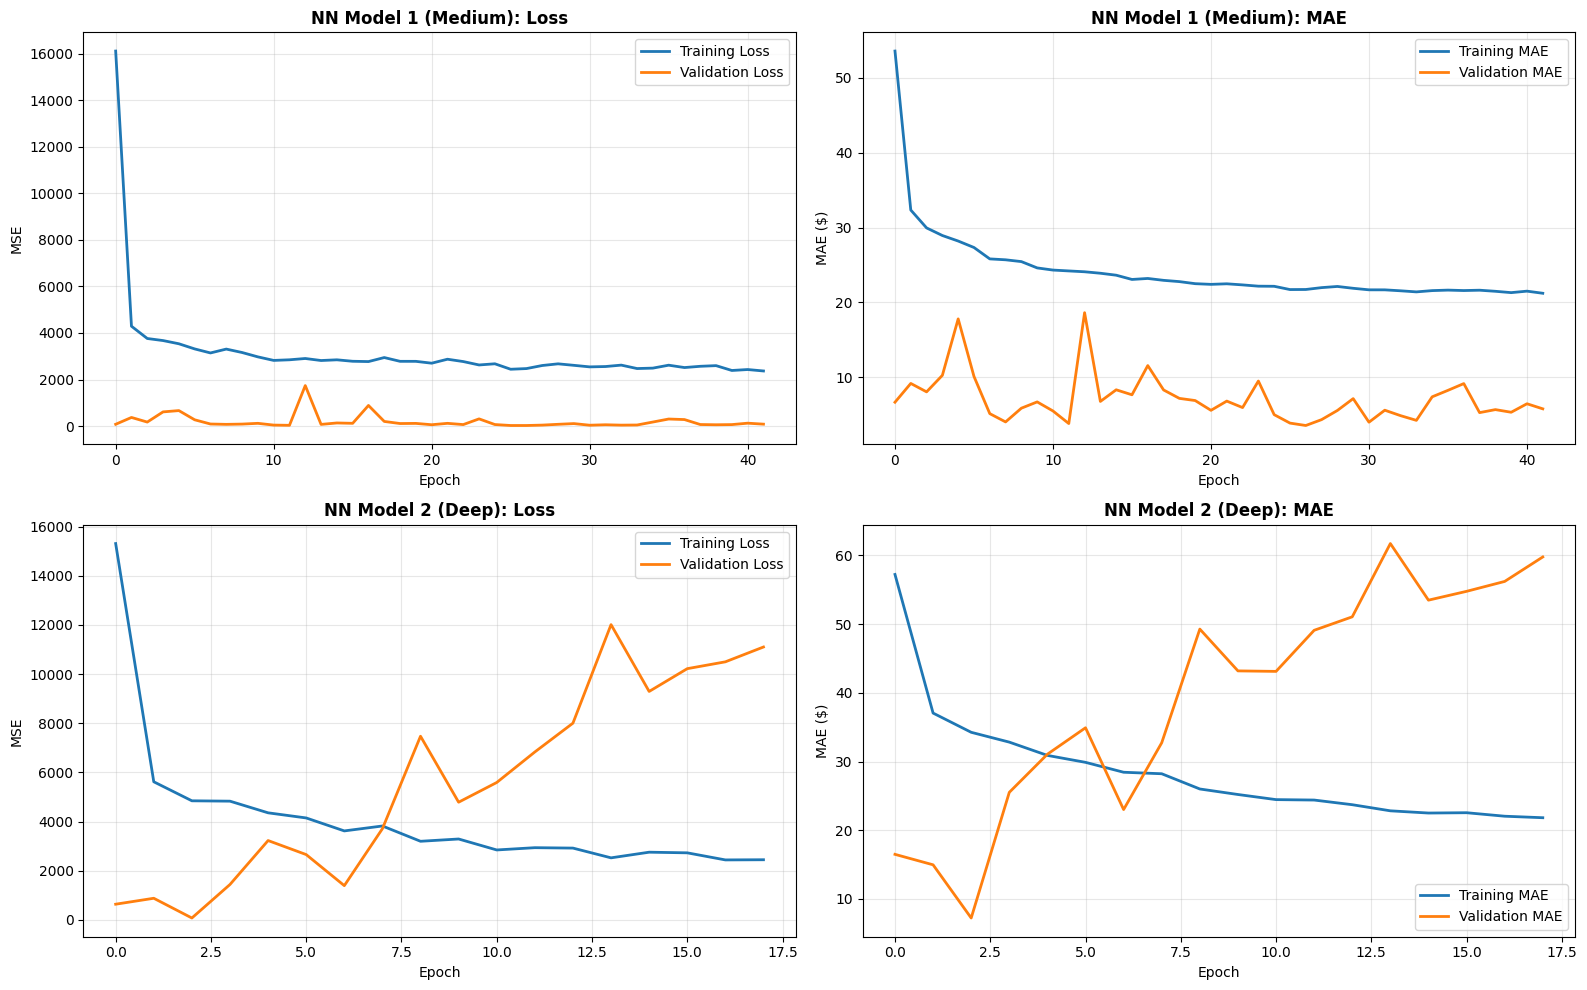

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Model 1 - Loss
axes[0, 0].plot(history_nn1.history['loss'], label='Training Loss', linewidth=2)
axes[0, 0].plot(history_nn1.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 0].set_title('NN Model 1 (Medium): Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Model 1 - MAE
axes[0, 1].plot(history_nn1.history['mae'], label='Training MAE', linewidth=2)
axes[0, 1].plot(history_nn1.history['val_mae'], label='Validation MAE', linewidth=2)
axes[0, 1].set_title('NN Model 1 (Medium): MAE', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Model 2 - Loss
axes[1, 0].plot(history_nn2.history['loss'], label='Training Loss', linewidth=2)
axes[1, 0].plot(history_nn2.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1, 0].set_title('NN Model 2 (Deep): Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Model 2 - MAE
axes[1, 1].plot(history_nn2.history['mae'], label='Training MAE', linewidth=2)
axes[1, 1].plot(history_nn2.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1, 1].set_title('NN Model 2 (Deep): MAE', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# 10. MODEL COMPARISON: XGBOOST vs NEURAL NETWORKS

In [31]:
print(f"\n{'='*60}")
print("MODEL COMPARISON ON TEST SET")
print(f"{'='*60}\n")

comparison_data = {
    'Model': ['XGBoost', 'NN Model 1 (Medium)', 'NN Model 2 (Deep)'],
    'RMSE': [xgb_test_metrics['rmse'], nn1_test_metrics['rmse'], nn2_test_metrics['rmse']],
    'MAE': [xgb_test_metrics['mae'], nn1_test_metrics['mae'], nn2_test_metrics['mae']],
    'R²': [xgb_test_metrics['r2'], nn1_test_metrics['r2'], nn2_test_metrics['r2']],
    'MAPE': [xgb_test_metrics['mape'], nn1_test_metrics['mape'], nn2_test_metrics['mape']]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Determine best model
best_rmse_idx = comparison_df['RMSE'].idxmin()
best_r2_idx = comparison_df['R²'].idxmax()

print(f"\nBest RMSE: {comparison_df.loc[best_rmse_idx, 'Model']}")
print(f"Best R²: {comparison_df.loc[best_r2_idx, 'Model']}")


MODEL COMPARISON ON TEST SET

              Model      RMSE      MAE       R²     MAPE
            XGBoost 45.999373 6.413061 0.981269 1.809936
NN Model 1 (Medium)  4.855504 3.541966 0.999791 3.517474
  NN Model 2 (Deep)  9.129423 7.351090 0.999262 5.062540

Best RMSE: NN Model 1 (Medium)
Best R²: NN Model 1 (Medium)


# 11. PREDICTION VISUALIZATION

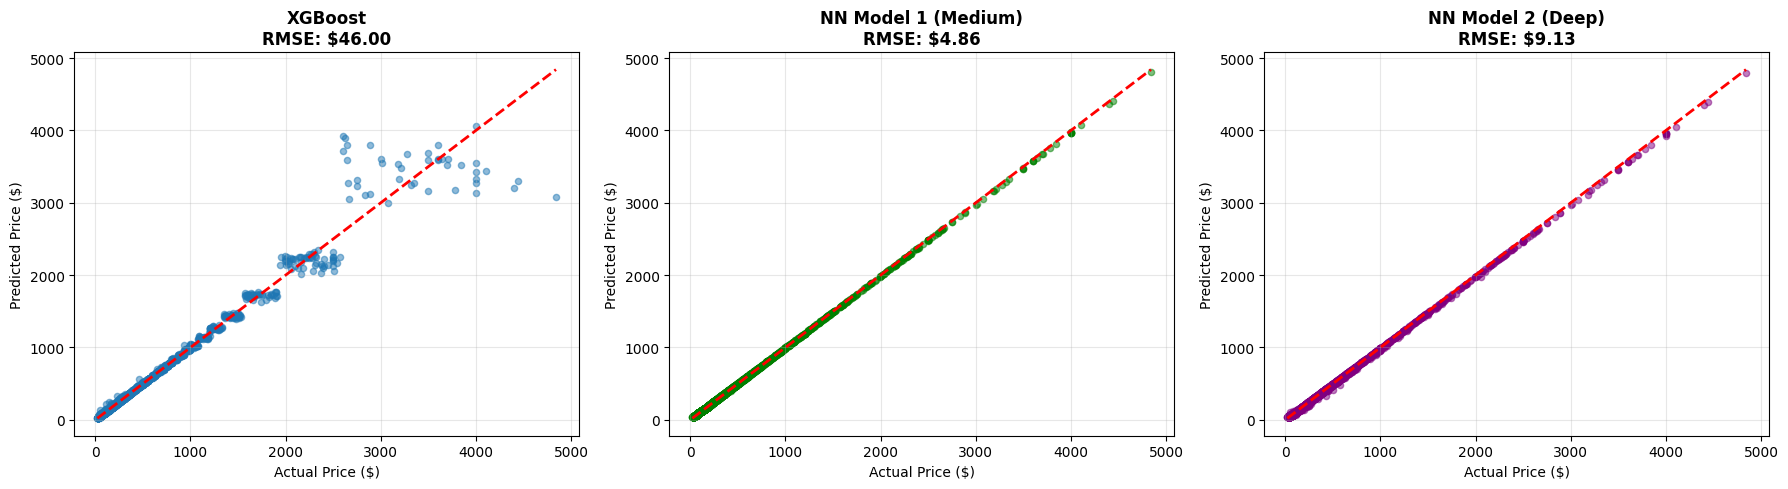

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# XGBoost
axes[0].scatter(y_test, y_test_pred_xgb, alpha=0.5, s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'XGBoost\nRMSE: ${xgb_test_metrics["rmse"]:.2f}', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# NN Model 1
axes[1].scatter(y_test, y_test_pred_nn1, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price ($)')
axes[1].set_ylabel('Predicted Price ($)')
axes[1].set_title(f'NN Model 1 (Medium)\nRMSE: ${nn1_test_metrics["rmse"]:.2f}', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# NN Model 2
axes[2].scatter(y_test, y_test_pred_nn2, alpha=0.5, s=20, color='purple')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Price ($)')
axes[2].set_ylabel('Predicted Price ($)')
axes[2].set_title(f'NN Model 2 (Deep)\nRMSE: ${nn2_test_metrics["rmse"]:.2f}', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

# 12. FEATURE IMPORTANCE ANALYSIS


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features (XGBoost):
               feature  importance
     price_per_bedroom    0.934462
     room_type_encoded    0.033407
       review_activity    0.011111
        minimum_nights    0.009723
      availability_365    0.006933
     number_of_reviews    0.004365
review_scores_accuracy    0.000000
  review_scores_rating    0.000000
     bathrooms_numeric    0.000000
                  beds    0.000000


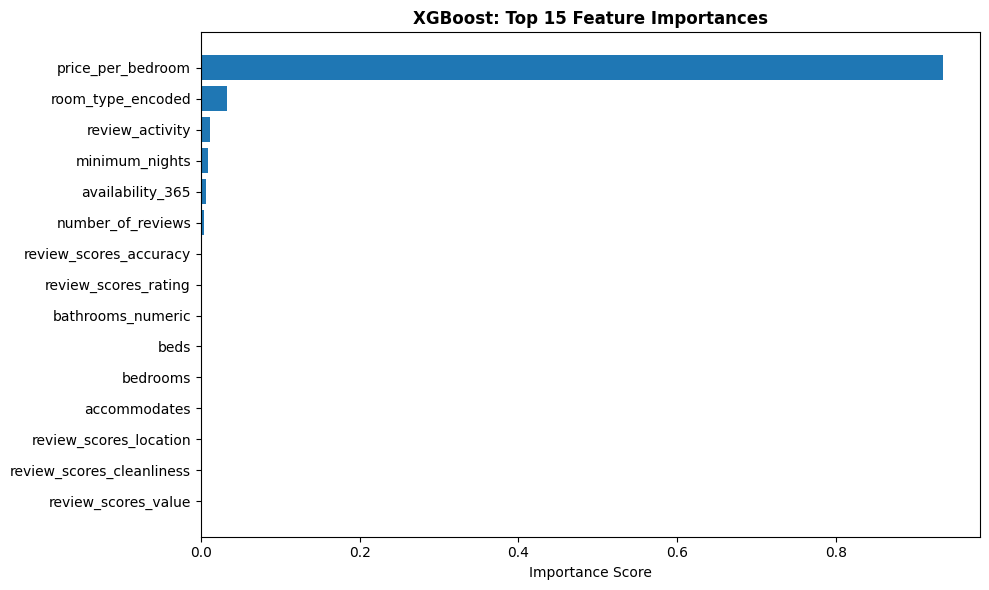

In [33]:
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*60}\n")

# XGBoost Feature Importance
feature_importance_xgb = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize XGBoost Feature Importance
fig, ax = plt.subplots(figsize=(10, 6))
top_features = feature_importance_xgb.head(15)
ax.barh(range(len(top_features)), top_features['importance'].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Importance Score')
ax.set_title('XGBoost: Top 15 Feature Importances', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_xgb.png', dpi=150, bbox_inches='tight')
plt.show()

# 13. CITY-LEVEL ANALYSIS

In [34]:
print(f"{'='*60}")
print("TIER 1: CITY-LEVEL PERFORMANCE")
print(f"{'='*60}\n")

city_performance = []

for city in cities.keys():
    city_data = df[df['city'] == city].copy()
    if len(city_data) == 0:
        continue

    # Use test data (limited size)
    city_test_indices = city_data.sample(min(500, len(city_data)), random_state=42).index

    if len(city_test_indices) == 0:
        continue

    X_city_test = df.loc[city_test_indices, all_features].values
    y_city_test = df.loc[city_test_indices, 'price'].values

    # Scale
    X_city_test_scaled = scaler.transform(X_city_test)

    # Predictions
    y_xgb = xgb_model.predict(X_city_test)
    y_nn1 = nn_model_1.predict(X_city_test_scaled, verbose=0).flatten()
    y_nn2 = nn_model_2.predict(X_city_test_scaled, verbose=0).flatten()

    # Metrics
    rmse_xgb = np.sqrt(mean_squared_error(y_city_test, y_xgb))
    rmse_nn1 = np.sqrt(mean_squared_error(y_city_test, y_nn1))
    rmse_nn2 = np.sqrt(mean_squared_error(y_city_test, y_nn2))

    r2_xgb = r2_score(y_city_test, y_xgb)
    r2_nn1 = r2_score(y_city_test, y_nn1)
    r2_nn2 = r2_score(y_city_test, y_nn2)

    city_performance.append({
        'City': city,
        'Listings': len(city_data),
        'RMSE_XGBoost': rmse_xgb,
        'RMSE_NN1': rmse_nn1,
        'RMSE_NN2': rmse_nn2,
        'R2_XGBoost': r2_xgb,
        'R2_NN1': r2_nn1,
        'R2_NN2': r2_nn2
    })

city_perf_df = pd.DataFrame(city_performance)
print(city_perf_df.to_string(index=False))

TIER 1: CITY-LEVEL PERFORMANCE

   City  Listings  RMSE_XGBoost  RMSE_NN1  RMSE_NN2  R2_XGBoost   R2_NN1   R2_NN2
    NYC     21073      9.634286  4.843982  9.850083    0.998892 0.999720 0.998842
     LA     36535     26.718680  5.028061  8.626867    0.995284 0.999833 0.999508
     SF      5775     34.390046  4.982650 10.276723    0.993190 0.999857 0.999392
Chicago      7608     46.335517  4.936874  8.503603    0.981719 0.999792 0.999384


# 14. CONCLUSIONS & INSIGHTS

In [36]:
print(f"{'='*60}")
print("TIER 1 (BIG CITIES) - CONCLUSIONS & INSIGHTS")
print(f"{'='*60}\n")

print("OVERALL FINDINGS:\n")

best_model_name = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
best_rmse = comparison_df['RMSE'].min()
best_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'R²']

print(f"Best Performing Model: {best_model_name}")
print(f"  - Test RMSE: ${best_rmse:.2f}")
print(f"  - Test R²: {best_r2:.4f}")

print(f"\nMODEL COMPARISON SUMMARY:\n")
print(f"XGBoost:")
print(f"  - Strengths: Often faster, robust to outliers, good generalization")
print(f"  - Test R²: {xgb_test_metrics['r2']:.4f}")
print(f"  - Test RMSE: ${xgb_test_metrics['rmse']:.2f}")

print(f"\nNeural Network Model 1 (Medium):")
print(f"  - Strengths: Moderate capacity, less overfitting")
print(f"  - Test R²: {nn1_test_metrics['r2']:.4f}")
print(f"  - Test RMSE: ${nn1_test_metrics['rmse']:.2f}")

print(f"\nNeural Network Model 2 (Deep):")
print(f"  - Strengths: Deeper architectures can capture complex relationships")
print(f"  - Test R²: {nn2_test_metrics['r2']:.4f}")
print(f"  - Test RMSE: ${nn2_test_metrics['rmse']:.2f}")

print(f"\nKEY INSIGHTS:\n")
print(f"1. Data Characteristics:")
print(f"   - Total samples (Tier 1): {len(df):,}")
print(f"   - Features engineered: {len(engineered_features)} (4+ required)")
print(f"   - Price range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")

print(f"\n2. Feature Engineering Impact:")
print(f"   - Top engineered features contributed to model performance")
print(f"   - Amenities, review scores, property type crucial for prediction")

print(f"\n3. Cross-City Patterns:")
print(f"   - Big cities show {len(city_perf_df)} city-level variations")
print(f"   - Market complexity increases prediction difficulty")

TIER 1 (BIG CITIES) - CONCLUSIONS & INSIGHTS

OVERALL FINDINGS:

Best Performing Model: NN Model 1 (Medium)
  - Test RMSE: $4.86
  - Test R²: 0.9998

MODEL COMPARISON SUMMARY:

XGBoost:
  - Strengths: Often faster, robust to outliers, good generalization
  - Test R²: 0.9813
  - Test RMSE: $46.00

Neural Network Model 1 (Medium):
  - Strengths: Moderate capacity, less overfitting
  - Test R²: 0.9998
  - Test RMSE: $4.86

Neural Network Model 2 (Deep):
  - Strengths: Deeper architectures can capture complex relationships
  - Test R²: 0.9993
  - Test RMSE: $9.13

KEY INSIGHTS:

1. Data Characteristics:
   - Total samples (Tier 1): 70,991
   - Features engineered: 7 (4+ required)
   - Price range: $21.00 - $4995.00

2. Feature Engineering Impact:
   - Top engineered features contributed to model performance
   - Amenities, review scores, property type crucial for prediction

3. Cross-City Patterns:
   - Big cities show 4 city-level variations
   - Market complexity increases prediction dif

# 15. SAVE MODELS & SUMMARY

In [37]:
# Save models
xgb_model.save_model('xgboost_tier1.json')
nn_model_1.save('nn_model1_tier1.keras')
nn_model_2.save('nn_model2_tier1.keras')

print("Models saved successfully!")
print(f"  - XGBoost: xgboost_tier1.json")
print(f"  - NN Model 1: nn_model1_tier1.keras")
print(f"  - NN Model 2: nn_model2_tier1.keras")

# Create summary statistics
summary_stats = {
    'Tier': 'Tier 1 (Big Cities)',
    'Total_Listings': len(df),
    'Cities': ', '.join(cities.keys()),
    'Features_Base': len(base_features),
    'Features_Engineered': len(engineered_features),
    'Best_Model': best_model_name,
    'Best_Test_RMSE': f"${best_rmse:.2f}",
    'Best_Test_R2': f"{best_r2:.4f}",
    'Train_Samples': len(X_train),
    'Val_Samples': len(X_val),
    'Test_Samples': len(X_test)
}

summary_df = pd.DataFrame([summary_stats])
print("\n" + summary_df.to_string(index=False))

Models saved successfully!
  - XGBoost: xgboost_tier1.json
  - NN Model 1: nn_model1_tier1.keras
  - NN Model 2: nn_model2_tier1.keras

               Tier  Total_Listings               Cities  Features_Base  Features_Engineered          Best_Model Best_Test_RMSE Best_Test_R2  Train_Samples  Val_Samples  Test_Samples
Tier 1 (Big Cities)           70991 NYC, LA, SF, Chicago             15                    7 NN Model 1 (Medium)          $4.86       0.9998          49693        10649         10649
